In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.manifold import MDS, TSNE
from sklearn.neighbors import DistanceMetric
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import io, os, re, time, itertools, requests
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from lprojection.util import get_N_HexCol
from collections import Counter
from lprojection.gnps import Gnps

In [2]:
def dissimilarity_matrix(gdict, minput='Cosine', anno=None, url_to_features=None):
    """ Calculates dissimilarity matrix based on defined input
    Parameters
    ----------
    gdict: dict 
        Dictionary containing node attributes and edge list from GNPS. 
    minput: str
        Workflow type ('MZmine' or 'V2').
    anno: pandas dataframe
        Annotation table with classyfire class assignment and InChI.
    url_to_features: str
        url do GNPS-MZmine job.
    Returns
        Dissimilarity matrix.
    -------
    """
    gnps = gdict['gnps']
    net = gdict['net']
    nlist = list(set(net['CLUSTERID1'].tolist()+net['CLUSTERID2'].tolist()))
    nlist.sort()
    nn = len(nlist)
    ndict = {}
    for n in range(nn):
        ndict[nlist[n]] = n
    if minput=='Cosine':
        m = np.empty([nn,nn])
        m[:nn, :nn] = 0
        for i in net.index:
            m[ndict[net.loc[i, 'CLUSTERID1']], ndict[net.loc[i, 'CLUSTERID2']]] = net.loc[i, 'Cosine']
            m[ndict[net.loc[i, 'CLUSTERID2']], ndict[net.loc[i, 'CLUSTERID1']]] = net.loc[i, 'Cosine']
        m = 1-m
    elif minput=='Feature intensities':
        features = pd.read_csv(io.StringIO(requests.get(url_to_features).text))
        features.index = features['row ID']
        dist = DistanceMetric.get_metric('canberra')
        m = dist.pairwise(features.loc[nlist][features.columns[3:]])
    elif minput=='Tanimoto':
        ginchi = pd.merge(gnps[['cluster index', 'parent mass', 'LibraryID']],
                          anno, left_on='cluster index', right_on='cluster index', how='left')
        ginchi.index = ginchi['cluster index']
        ginchi = ginchi.loc[list(ndict.keys())]
        mols = []
        for x in ginchi['INCHI']:
            try:
                mols.append(Chem.MolFromInchi(x))
            except:
                mols.append('')
        m = np.empty([nn,nn])
        m[:nn, :nn] = 0
        for i in net.index:
            p1 = np.where(ginchi.index==net.loc[i, 'CLUSTERID1'])[0][0]
            p2 = np.where(ginchi.index==net.loc[i, 'CLUSTERID2'])[0][0]
            try:
                fp1 = AllChem.GetMorganFingerprint(mols[p1],2)
                fp2 = AllChem.GetMorganFingerprint(mols[p2],2)
                m[ndict[net.loc[i, 'CLUSTERID1']], ndict[net.loc[i, 'CLUSTERID2']]] = DataStructs.TanimotoSimilarity(fp1,fp2)
                m[ndict[net.loc[i, 'CLUSTERID2']], ndict[net.loc[i, 'CLUSTERID1']]] = DataStructs.TanimotoSimilarity(fp1,fp2)
            except:
                m[ndict[net.loc[i, 'CLUSTERID1']], ndict[net.loc[i, 'CLUSTERID2']]] = net.loc[i, 'Cosine']
                m[ndict[net.loc[i, 'CLUSTERID2']], ndict[net.loc[i, 'CLUSTERID1']]] = net.loc[i, 'Cosine']
        m = 1-m
    return m

In [3]:
# Retrieve node attribute and edge list from GNPS for two jobs.
# The first with minimal cosine threshold and matching peaks (https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=4fd90fa52ade4bdcb604945952964fa0)
# to calculate the dimension reduction
# The second, with standard data analysis parameters (https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=608e5eb3402f4dd599fcc88b1c8a40e9) 
# to display the connections between the edges in the graph
taskid = '4fd90fa52ade4bdcb604945952964fa0,608e5eb3402f4dd599fcc88b1c8a40e9'
workflow = 'V2'
gdict = Gnps(taskid, workflow).getGnps()

In [4]:
# Set parameters
scaling_factor = 30 # node size for .GML graph export
projection = 'TSNE' # projection type

# tsne parameters 
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
liter = 1000
perp=6
learn=200

meta = '../data/associated_meta_inchi_match_full.tsv' # metadata file
metac = 'superclass_name' # metadata field to use on file 
#cthr=0.7 # Cosine threshold to display edges on GML graph output
minput='Cosine'

anno = pd.read_table(meta) # load metadata matrix
anno.head()

,cluster index,parent.mass,LibraryID,INCHI,superclass_name,class_name
0,1,319.086,"2-((4,6-Dimethyl-2-pyrimidinyl)thio)-N-(3-nitr...",InChI=1S/C14H14N4O3S/c1-9-6-10(2)16-14(15-9)22...,Benzenoids,Benzene and substituted derivatives
1,2,362.053,N-(3-Nitrophenyl)-2-((4-methyl-5-(trifluoromet...,"InChI=1S/C12H10F3N5O3S/c1-19-10(12(13,14)15)17...",Benzenoids,Benzene and substituted derivatives
2,3,311.027,"N-(3-Nitrophenyl)-2-((5-methyl-1,3,4-thiadiazo...",InChI=1S/C11H10N4O3S2/c1-7-13-14-11(20-7)19-6-...,Benzenoids,Benzene and substituted derivatives
3,5,310.216,Methadone,InChI=1S/C21H27NO/c1-5-20(23)21(16-17(2)22(3)4...,Phenylpropanoids and polyketides,Flavonoids
4,6,212.128,Methoxamine,InChI=1S/C11H17NO3/c1-7(12)11(13)9-6-8(14-2)4-...,Benzenoids,Benzene and substituted derivatives


In [5]:
# Format cosine dissimilarity matrix
m = dissimilarity_matrix(gdict, minput) 
#m.shape
m[:5,:5]

array([[1.    , 0.0256, 0.0617, 1.    , 1.    ],
       [0.0256, 1.    , 0.0301, 1.    , 1.    ],
       [0.0617, 0.0301, 1.    , 1.    , 1.    ],
       [1.    , 1.    , 1.    , 1.    , 1.    ],
       [1.    , 1.    , 1.    , 1.    , 1.    ]])

In [6]:
G1=nx.Graph() # one graph for standard layout (not very useful, cytoscape layouts are better)
G2=nx.Graph() # one graph for 'feature relationship layout'
if gdict['net1'] is not None: # if there is alternative GNPS display job
    net1 = gdict['net1']
    edge_list = net1[['CLUSTERID1', 'CLUSTERID2']].apply(lambda a: tuple(a.tolist()), axis=1).tolist()
else:
    edge_list = net[['CLUSTERID1', 'CLUSTERID2']].apply(lambda a: tuple(a.tolist()), axis=1).tolist()
    
G1.add_edges_from(edge_list)
G2.add_edges_from(edge_list)

In [7]:
# Perform dimension reduction with parameters as defined above
if projection=='MDS':
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    m_transformed = embedding.fit_transform(m)
elif projection=='TSNE':
    m_transformed = TSNE(n_components=2, n_iter=liter, perplexity=perp,
                         learning_rate=learn, metric="precomputed").fit_transform(m)

In [8]:
# Few test gnps attributes
gnps = gdict['gnps']
net = gdict['net']
nlist = list(set(net['CLUSTERID1'].tolist()+net['CLUSTERID2'].tolist()))
nlist.sort()
nn = len(nlist)
ndict = {} 
# Graph node index, GNPS cluster index relationship 
for n in range(nn):
    ndict[nlist[n]] = n
  
gnps = gnps[['cluster index', 'parent mass', 'LibraryID']]
if meta!='':
    anno.drop(['parent.mass', 'LibraryID', 'INCHI'], axis=1, inplace=True)
    gnps = pd.merge(gnps, anno, left_on='cluster index', right_on='cluster index', how='left')
    gnps.fillna('', inplace=True)
    if metac in gnps.columns:
        gnps.loc[gnps[metac]=='', metac] = 'unassigned'
    # How to create n distinct colors for each class to color nodes
    lcol = np.array(list(set(gnps[metac])))
    if len(lcol)>1:
        col = get_N_HexCol(len(lcol))
        dcol = dict(zip(lcol, col))
    gcol = {}

In [9]:
# Assign one color for each node based on class
gnps.index = gnps['cluster index']
gnps.columns = gnps.columns.str.replace(' ', '')
gnps.columns = gnps.columns.str.replace('_', '')
for key, value in ndict.items():
    dtmp = gnps.loc[key].to_dict()
    if meta!='':
        gcol[gnps.loc[key, 'clusterindex']] = dcol[gnps.loc[key, metac.replace('_', '')]]
    for k, v in dtmp.items():
        nx.set_node_attributes(G1, name=k, values={key: v})
        nx.set_node_attributes(G2, name=k, values={key: v})

In [10]:
taskid = taskid.split(',')
staskid = taskid[0][:10]

ptmp=nx.fruchterman_reingold_layout(G1) # networkx current choice for automated layout
pos1 = {}
for kp, vp in ptmp.items():
    if meta!='':
        pos1[kp] = {'x' : 100*scaling_factor*ptmp[kp][0], 'y' : 100*scaling_factor*ptmp[kp][1], 'fill': gcol[kp] }
    else:
        pos1[kp] = { 'x' : 100*scaling_factor*ptmp[kp][0], 'y' : 100*scaling_factor*ptmp[kp][1]}

nx.set_node_attributes(G1,name='graphics', values=pos1) # add position and color
nx.write_gml(G1, staskid+metac+'.gml', str) # write gml file with taskid in the name

In [11]:
# use reduced dimensions to create layout
pos = {}
for key, value in ndict.items():
    #G.node[key]['x'] = float(m_transformed[value,0])
    #G.node[key]['y'] = float(m_transformed[value,1])
    if meta!='':
        pos[key] = {'x' : scaling_factor*float(m_transformed[value,0]), 'y' : scaling_factor*float(m_transformed[value,1]), 'fill': gcol[key] }
    else:
        pos[key] = {'x' : scaling_factor*float(m_transformed[value,0]), 'y' : scaling_factor*float(m_transformed[value,1]) }
#nx.write_graphml(G, "cosine_mds.graphml") 
nx.set_node_attributes(G2, name='graphics',values=pos)
nx.write_gml(G2, staskid+projection+minput+metac+'.gml', str)

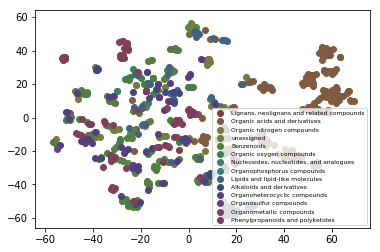

In [12]:
# 2D layout colored by chemical super class
gnps = gnps.loc[list(ndict.keys())]
fig, ax = plt.subplots()
for kk, vv  in dcol.items():
    x = m_transformed[gnps[metac.replace('_', '')]==kk, :][:,0]
    y = m_transformed[gnps[metac.replace('_', '')]==kk, :][:,1]
    ax.scatter(x, y, c=vv,  label=kk)

ax.legend(fontsize=6)

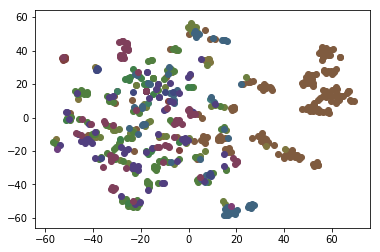

In [13]:
fig, ax = plt.subplots()
for kk, vv  in dcol.items():
    x = m_transformed[gnps[metac.replace('_', '')]==kk, :][:,0]
    y = m_transformed[gnps[metac.replace('_', '')]==kk, :][:,1]
    ax.scatter(x, y, c=vv,  label=kk)


In [14]:
# add your conda path, if necessary, to run the scrip
os.environ['PATH'] += ':'+'/home/rsilva/miniconda3/envs/lproj/bin'

In [18]:
!layout_script  --help

Usage: layout_script [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  layout
  tsne-optim


In [19]:
# repeat the process above on command line
!layout_script layout \
    --taskid '4fd90fa52ade4bdcb604945952964fa0,608e5eb3402f4dd599fcc88b1c8a40e9' \
    --projection TSNE \
    --workflow V2 \
    --scaling 30 \
    --linput Cosine \
    --cthr 0.7 \
    --meta ../data/associated_meta_inchi_match_full.tsv \
    --metac superclass_name

Traceback (most recent call last):
  File "/home/rsilva/miniconda3/envs/lproj/bin/layout_script", line 320, in <module>
    layout_script()
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 956, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 555, in invoke
    return callback(*args, **kwargs)
  File "/home/rsilva/miniconda3/envs/lproj/bin/layout_script", line 86, in layout
    m = dissimilarity_matrix(g

In [ ]:
!layout_script layout \
    --taskid '4fd90fa52ade4bdcb604945952964fa0,608e5eb3402f4dd599fcc88b1c8a40e9' \
    --projection TSNE \
    --workflow V2 \
    --scaling 30 \
    --linput Cosine \
    --cthr 0.7 \
    --meta ../data/associated_meta_inchi_match_full.tsv \
    --metac superclass_name

In [32]:
# repeat the process with Tanimoto instead of cosine
!layout_script layout \
    --taskid '4fd90fa52ade4bdcb604945952964fa0,608e5eb3402f4dd599fcc88b1c8a40e9' \
    --projection TSNE \
    --workflow V2 \
    --scaling 30 \
    --linput Tanimoto \
    --cthr 0.7 \
    --meta ../data/associated_meta_inchi_match_full.tsv \
    --metac superclass_name

Traceback (most recent call last):
  File "/home/rsilva/miniconda3/envs/lproj/bin/layout_script", line 363, in <module>
    layout_script()
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 956, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/rsilva/miniconda3/envs/lproj/lib/python3.5/site-packages/click/core.py", line 555, in invoke
    return callback(*args, **kwargs)
  File "/home/rsilva/miniconda3/envs/lproj/bin/layout_script", line 232, in layout
    for key, value in ndict2.